In [ ]:
!pip install pomegranate

In [ ]:
from pomegranate import *

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
mydb = pd.read_csv("insurance.csv", dtype = str)

In [ ]:
mydb = mydb.head(3000)#оставляем первые 3000 наблюдений без какой-то логики /случайным образом

Оставим только 6 наиболее интересных переменных  - хороший ученик, возраст, социально-экономический статус, качество вождения (характеристики, которые связаны с личностью человека), расходы на застрахованный автомобиль (как целевая переменная) и тип окресности.

In [ ]:
mydb = mydb[['GoodStudent','Age','SocioEcon','DrivQuality','ThisCarCost','HomeBase']]

In [ ]:
mydb.head()

,GoodStudent,Age,SocioEcon,DrivQuality,ThisCarCost,HomeBase
0,False,Adult,Prole,Poor,TenThou,City
1,False,Senior,Prole,Normal,Thousand,City
2,False,Senior,UpperMiddle,Excellent,Thousand,City
3,False,Adolescent,Middle,Normal,Thousand,Suburb
4,False,Adolescent,Prole,Poor,TenThou,City


Удалим пропущенные значения для построения структуры 

In [ ]:
mydb = mydb.dropna()

In [ ]:
# need pygraphviz http://pygraphviz.github.io/documentation/pygraphviz-1.3.1/install.html
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail18 amd64 2.24.32-1ubuntu1 [14.2 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail-common amd64 2.24.32

In [ ]:
from pygraphviz import *

Построим байесовскую сеть

Первый алгоритм  - Chow-Liu

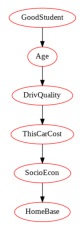

In [ ]:
bnet_cl = BayesianNetwork.from_samples(mydb, algorithm='chow-liu')
colnames  = mydb.columns
for i in range(mydb.shape[1]):
  bnet_cl.states[i].name = colnames[i]
bnet_cl.plot()

In [ ]:
bnet_cl.bake()#зафиксируем

Второй алгоритм - Greedy

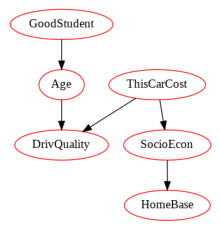

In [ ]:
bnet_g = BayesianNetwork.from_samples(mydb, algorithm='greedy')
for i in range(mydb.shape[1]):
  bnet_g.states[i].name = colnames[i]
bnet_g.plot()

In [ ]:
bnet_g.bake()#зафиксируем

Третий алгоритм - Exact

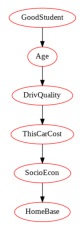

In [ ]:
bnet_e = BayesianNetwork.from_samples(mydb, algorithm='exact')
for i in range(mydb.shape[1]):
  bnet_e.states[i].name = colnames[i]
bnet_e.plot()

In [ ]:
bnet_e.bake()#зафиксируем

Сравним полученные модели, используя метрику "правдоподобия"

Посмотрим на общую оценку полученных сетей

In [ ]:
X = mydb.to_numpy()
#для каждой комбинации считаем вероятность того, что она могла быть и складываем вместе //некая метрика правдоподобия

In [ ]:
print("Chow-Liu:", bnet_cl.log_probability(X).sum())
print("Greedy:", bnet_g.log_probability(X).sum())
print("Exact:", bnet_e.log_probability(X).sum())

Chow-Liu: -13384.95165480621
Greedy: -13417.23735234921
Exact: -13384.95165480621


Модель, которая имеет оценку ближе к 0 является лучшей. В данном случае модели, построенные с использованием алгоритмов Chow-Liu и Exact получили одинаковую наилучшую оценку. Для дальнейшего анализа используем первую модель.

Посмотрим как будут меняться расходы на застрахованный автомобиль (ThisCarCost), при изменении других переменных

Изначально посмотрим распределение для ThisCarCost

In [ ]:
initialProba = bnet_cl.predict_proba([[ None, None, None, None, None, None]])#свидетельство

In [ ]:
initialProba[0][4].parameters

[{'HundredThou': 0.04900000000000034,
  'Million': 0.0016666666666671072,
  'TenThou': 0.1290000000000002,
  'Thousand': 0.8203333333333322}]

1. Какова вероятность получить низкий уровень расходов на застрахованный автомобиль (Thousand) в младшем возрасте, среднем социально-экономическом статусе, низком качестве вождения, в городе, учитывая статус плохого ученика (GoodStudent=False)

In [ ]:
mydb.columns# порядок переменных в данных

Index(['GoodStudent', 'Age', 'SocioEcon', 'DrivQuality', 'ThisCarCost',
       'HomeBase'],
      dtype='object')

In [ ]:
bnet_cl.predict_proba([['False', "Adolescent","Middle", "Poor", None, "City"]])[0][4].parameters

[{'HundredThou': 0.14793654554460062,
  'Million': 0.002480231774071435,
  'TenThou': 0.3322356981081417,
  'Thousand': 0.5173475245731862}]

Вероятность значительно уменьшилась, посмотрим какое влияние оказывает качество вождения

2. Как изменится эта вероятность в той же ситуации, но увеличив качество вождения до самого высокого (Excellent)

In [ ]:
bnet_cl.predict_proba([['False', "Adolescent","Middle", "Excellent", None, "City"]])[0][4].parameters

[{'HundredThou': 0.004263756662045946,
  'Million': 0.0,
  'TenThou': 0.014576098356295234,
  'Thousand': 0.9811601449816587}]

Мы получили почти единицу, это может говорить о том, что на уровень расходов на автомобиль качество вождения оказывает значительное влияние

3. Попробуем изменить статус ученика на хороший, возраст на средний и социальный статус на максимальный

In [ ]:
bnet_cl.predict_proba([['True', "Adult","Wealthy", "Excellent", None, "City"]])[0][4].parameters

[{'HundredThou': 0.0,
  'Million': 0.0,
  'TenThou': 0.003927272059936963,
  'Thousand': 0.9960727279400534}]

Вероятность тоже немного увеличилась, но так как в предыдущем случае увеличение было гораздо больше, это может говорить о том, что изменение других переменных  не особо влияет на уровень расходов, а изменение качества вождения как раз сильно влияет на уровень расходов на застрахованный автомобиль -- чем выше качество, тем выше вероятность малых расходов.


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y = mydb.ThisCarCost
X = mydb.drop(columns = "ThisCarCost")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

In [ ]:
df = pd.concat([X_train, y_train], axis=1)

In [ ]:
df.head()

,GoodStudent,Age,SocioEcon,DrivQuality,HomeBase,ThisCarCost
713,False,Adult,Middle,Poor,Secure,TenThou
2921,False,Adult,Middle,Poor,Rural,Thousand
2678,False,Adult,Middle,Normal,Suburb,Thousand
2687,False,Adult,Middle,Normal,Suburb,Thousand
2235,False,Adult,UpperMiddle,Poor,Secure,Thousand


Строим модель

In [ ]:
bnet_n = BayesianNetwork.from_samples(df, algorithm='chow-liu') #выбираем данный алгоритм, потому что в прошлом случае он показал лучшее качество 

Предсказание

In [ ]:
df_p = pd.concat([X_test, y_test], axis=1)

In [ ]:
df_p_n=df_p 
df_p_n["ThisCarCost"]=None
df_p_n.head()

,GoodStudent,Age,SocioEcon,DrivQuality,HomeBase,ThisCarCost
311,False,Adult,UpperMiddle,Normal,Suburb,None
1025,False,Senior,Prole,Normal,City,None
1587,False,Adolescent,Prole,Poor,City,None
2941,False,Adult,Middle,Normal,Secure,None
2980,False,Adolescent,Middle,Poor,Suburb,None


In [ ]:
print(df_p_n[0:].to_numpy())

[['False' 'Adult' 'UpperMiddle' 'Normal' 'Suburb' None]
 ['False' 'Senior' 'Prole' 'Normal' 'City' None]
 ['False' 'Adolescent' 'Prole' 'Poor' 'City' None]
 ...
 ['False' 'Adolescent' 'Prole' 'Poor' 'Rural' None]
 ['False' 'Adult' 'Middle' 'Normal' 'City' None]
 ['False' 'Adult' 'Middle' 'Excellent' 'Secure' None]]


In [ ]:
bnet_n.bake()

In [ ]:
tr_pred = bnet_n.predict(df_p_n.to_numpy()) 

In [ ]:
print(tr_pred)

[array(['False', 'Adult', 'UpperMiddle', 'Normal', 'Suburb', 'Thousand'],
      dtype=object), array(['False', 'Senior', 'Prole', 'Normal', 'City', 'Thousand'],
      dtype=object), array(['False', 'Adolescent', 'Prole', 'Poor', 'City', 'Thousand'],
      dtype=object), array(['False', 'Adult', 'Middle', 'Normal', 'Secure', 'Thousand'],
      dtype=object), array(['False', 'Adolescent', 'Middle', 'Poor', 'Suburb', 'Thousand'],
      dtype=object), array(['False', 'Adolescent', 'Prole', 'Poor', 'City', 'Thousand'],
      dtype=object), array(['True', 'Adolescent', 'Middle', 'Poor', 'Suburb', 'Thousand'],
      dtype=object), array(['False', 'Adolescent', 'Prole', 'Poor', 'Rural', 'Thousand'],
      dtype=object), array(['False', 'Senior', 'Middle', 'Normal', 'Secure', 'Thousand'],
      dtype=object), array(['False', 'Adult', 'Middle', 'Poor', 'Suburb', 'Thousand'],
      dtype=object), array(['False', 'Senior', 'Middle', 'Normal', 'Secure', 'Thousand'],
      dtype=object), array(['Fal

In [ ]:
df_pred = pd.DataFrame(tr_pred)

In [ ]:
newdf = df_pred[df_pred.columns[5]]

In [ ]:
newdf

0      Thousand
1      Thousand
2      Thousand
3      Thousand
4      Thousand
         ...   
995    Thousand
996    Thousand
997    Thousand
998    Thousand
999    Thousand
Name: 5, Length: 1000, dtype: object

In [ ]:
from sklearn import metrics

In [ ]:
metrics.accuracy_score(y_test, newdf)

0.827

Точность предсказания 82,7%, это говорит о том, что модель лучше доработать, чтобы использовать в жизни